### Step 1: Import Required Libraries

We import libraries for data manipulation (`pandas`, `numpy`), scaling (`MinMaxScaler`), evaluation metrics (`mean_absolute_error`, `mean_squared_error`), plotting (`matplotlib`), and building the LSTM model using TensorFlow Keras.

These libraries form the base for data preparation, model building, training, and evaluation.


In [6]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense


### Step 2: Load Tesla Stock Price Dataset

We load the Tesla stock price data from the CSV file using pandas, parsing the 'Date' column as the index.

Examining the first few rows confirms successful loading and gives insight into the dataset structure.


In [8]:
df = pd.read_csv('Tesla.csv', parse_dates=['Date'], index_col='Date')
print(df.head())


                 Open   High        Low      Close    Volume  Adj Close
Date                                                                   
2010-06-29  19.000000  25.00  17.540001  23.889999  18766300  23.889999
2010-06-30  25.790001  30.42  23.299999  23.830000  17187100  23.830000
2010-07-01  25.000000  25.92  20.270000  21.959999   8218800  21.959999
2010-07-02  23.000000  23.10  18.709999  19.200001   5139800  19.200001
2010-07-06  20.000000  20.00  15.830000  16.110001   6866900  16.110001


### Step 3: Preprocess Data

- We extract the 'Open' price as the feature to predict next day's open price.
- Prices are scaled to the range [0, 1] using `MinMaxScaler` for stable and fast training.
- We convert the time series into sequences where each input sample consists of 60 days of previous prices to predict the 61st day's price.
- The dataset is split into training and test sets without shuffling to maintain temporal order.
- Finally, the sequences are reshaped to 3D arrays required by LSTM layers: (samples, timesteps, features).


In [9]:
open_prices = df[['Open']].values

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_prices = scaler.fit_transform(open_prices)

def create_sequences(data, seq_length=60):
    X, y = [], []
    for i in range(seq_length, len(data)):
        X.append(data[i-seq_length:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

X, y = create_sequences(scaled_prices, 60)

split_idx = int(0.8 * len(X))
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))


### Step 4: Build and Compile LSTM Model

- The model contains two LSTM layers with 50 units each, the first returns sequences to feed next layer.
- A Dense layer with 1 neuron outputs the predicted price.
- The model is compiled with the Adam optimizer and mean squared error loss appropriate for regression tasks.


In [12]:
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)),
    LSTM(50),
    Dense(1)
])

model.compile(optimizer='adam', loss='mean_squared_error')


### Step 5: Train the Model

The LSTM is trained for 30 epochs with batch size 32 and 10% validation split to monitor generalization. Early stopping callbacks can be added to prevent overfitting.



In [13]:
history = model.fit(X_train, y_train, epochs=30, batch_size=32, validation_split=0.1)


Epoch 1/30
37/37 ━━━━━━━━━━━━━━━━━━━━ 6s 72ms/step - loss: 0.0340 - val_loss: 0.0027
Epoch 2/30
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - loss: 0.0017 - val_loss: 0.0023
Epoch 3/30
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - loss: 0.0013 - val_loss: 0.0026
Epoch 4/30
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - loss: 0.0013 - val_loss: 0.0020
Epoch 5/30
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - loss: 0.0012 - val_loss: 0.0021
Epoch 6/30
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - loss: 0.0012 - val_loss: 0.0027
Epoch 7/30
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step - loss: 0.0012 - val_loss: 0.0024
Epoch 8/30
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - loss: 0.0012 - val_loss: 0.0017
Epoch 9/30
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - loss: 0.0010 - val_loss: 0.0020
Epoch 10/30
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 64ms/step - loss: 0.0011 - val_loss: 0.0017
Epoch 11/30
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 63ms/step - loss: 9.4352e-04 - val_loss: 0.0019
Epoch 12/30
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step - loss:

### Step 6: Evaluate the Model

- We predict the stock prices on the test set.
- Predictions and true values are inverse-scaled to original price range.
- We compute Mean Absolute Error (MAE) and Root Mean Squared Error (RMSE) to quantify prediction accuracy.


In [14]:
y_pred = model.predict(X_test)

y_pred_rescaled = scaler.inverse_transform(y_pred)
y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1))

mae = mean_absolute_error(y_test_rescaled, y_pred_rescaled)
rmse = np.sqrt(mean_squared_error(y_test_rescaled, y_pred_rescaled))

print(f"MAE: {mae}")
print(f"RMSE: {rmse}")


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step
MAE: 6.091084897293697
RMSE: 7.99137128484284


### Step 7: Visualize Predictions vs Actual Prices

Plotting predicted and actual stock prices helps visually assess how well the LSTM model follows real price trends over time.


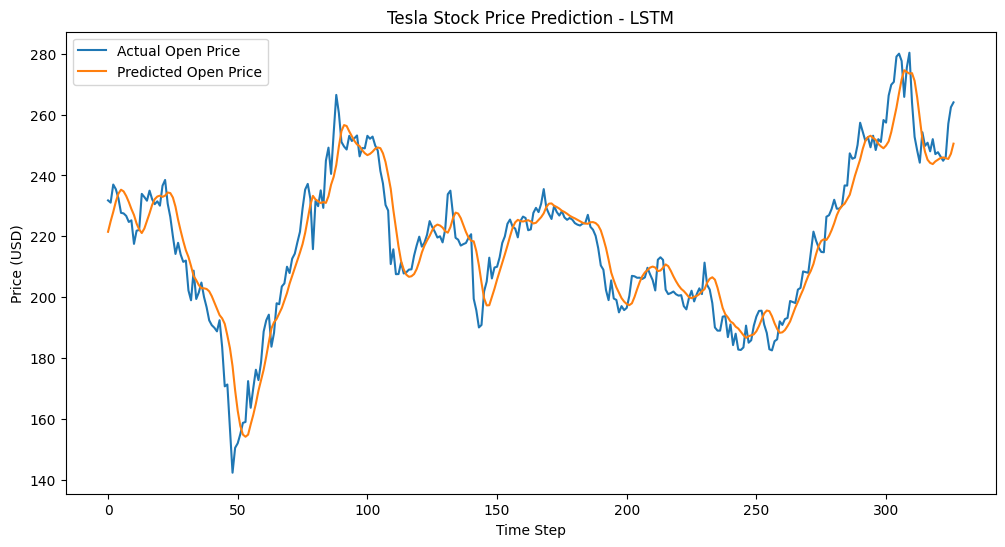

In [15]:
plt.figure(figsize=(12,6))
plt.plot(y_test_rescaled, label='Actual Open Price')
plt.plot(y_pred_rescaled, label='Predicted Open Price')
plt.title('Tesla Stock Price Prediction - LSTM')
plt.xlabel('Time Step')
plt.ylabel('Price (USD)')
plt.legend()
plt.show()
